In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/HI-Medium_Trans.csv', low_memory=False)

# Business logic: remove formats with no suspicious activity
df = df[~df['Payment Format'].isin(['Reinvestment', 'Wire'])]

# New feature columns
df['currency_change'] = np.where(df['Receiving Currency'] != df['Payment Currency'], 1, 0)
df['self_to_self'] = np.where(df['Account'] == df['Account.1'], 1, 0)

df.rename(columns={
    "Timestamp": "timestamp",
    "From Bank": "from_bank",
    "Account": "from_account",
    "To Bank": "to_bank",
    "Account.1": "to_account",
    "Amount Received": "amount_received",
    "Receiving Currency": "receiving_currency",
    "Amount Paid": "amount_paid",
    "Payment Currency": "payment_currency",
    "Payment Format": "payment_format",
    "Is Laundering": "is_laundering"
}, inplace=True) 

bank_filter = 11

if bank_filter is not None: # Filter by from_bank if needed -- vaibhav edit 
    df = df[df["from_bank"] == bank_filter]

# Minimal preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['tx_hour'] = df['timestamp'].dt.hour
df['tx_day'] = df['timestamp'].dt.dayofweek
df['tx_month'] = df['timestamp'].dt.month

# Encode categorical fields
from sklearn.preprocessing import LabelEncoder

# Encode categorical fields
for col in ['from_bank', 'to_bank', 'payment_format', 'receiving_currency', 'payment_currency']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Feature set
features = [
    'amount_received', 'amount_paid', 'tx_hour', 'tx_day', 'tx_month',
    'payment_format', 'currency_change', 'self_to_self',
    'receiving_currency', 'payment_currency', 'from_bank', 'to_bank',
] # Can add from_bank, to_bank if needed
target = 'is_laundering'

df_model = df[features + [target]].dropna()


Prepare tensors with gaussian noise

In [14]:
from sklearn.preprocessing import StandardScaler
import torch

X = StandardScaler().fit_transform(df_model[features])
y = df_model[target].astype(np.float32).values.reshape(-1, 1)

# Add small Gaussian noise to features
noise = np.random.normal(0, 0.01, X.shape)
X += noise

# Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [15]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1024)
test_dl = DataLoader(test_ds, batch_size=1024)


Simple regularized model

In [16]:
import torch.nn as nn

class AMLNet(nn.Module):
    def __init__(self, input_dim):
        super(AMLNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)  # No sigmoid here
        )

    def forward(self, x):
        return self.model(x)


model = AMLNet(X.shape[1])


Training loop and early stopping rounds

Epoch 1 - Train Loss: 1.0878, Val Loss: 0.6884
Epoch 2 - Train Loss: 0.5360, Val Loss: 0.4213
Epoch 3 - Train Loss: 0.4329, Val Loss: 0.3957
Epoch 4 - Train Loss: 0.4250, Val Loss: 0.3805
Epoch 5 - Train Loss: 0.4066, Val Loss: 0.3735
Epoch 6 - Train Loss: 0.3846, Val Loss: 0.3700
Epoch 7 - Train Loss: 0.4018, Val Loss: 0.3722
Epoch 8 - Train Loss: 0.3918, Val Loss: 0.3650
Epoch 9 - Train Loss: 0.3780, Val Loss: 0.3657
Epoch 10 - Train Loss: 0.3799, Val Loss: 0.3623
Epoch 11 - Train Loss: 0.3802, Val Loss: 0.3613
Epoch 12 - Train Loss: 0.3768, Val Loss: 0.3614
Epoch 13 - Train Loss: 0.3652, Val Loss: 0.3572
Epoch 14 - Train Loss: 0.3629, Val Loss: 0.3555
Epoch 15 - Train Loss: 0.3612, Val Loss: 0.3570
Epoch 16 - Train Loss: 0.3673, Val Loss: 0.3576
Epoch 17 - Train Loss: 0.3698, Val Loss: 0.3512
Epoch 18 - Train Loss: 0.3641, Val Loss: 0.3510
Epoch 19 - Train Loss: 0.3705, Val Loss: 0.3511
Epoch 20 - Train Loss: 0.3620, Val Loss: 0.3491
Epoch 21 - Train Loss: 0.3607, Val Loss: 0.3472
E

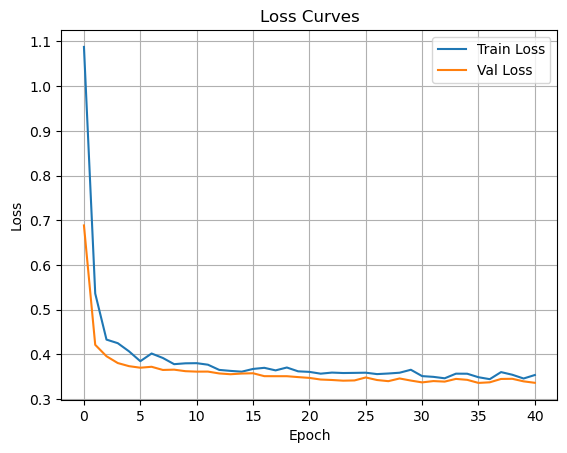

In [17]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Calculate positive class weight
positive_weight = (df_model['is_laundering'] == 0).sum() / (df_model['is_laundering'] == 1).sum()
pos_weight_tensor = torch.tensor([positive_weight], dtype=torch.float32)

# Use BCEWithLogitsLoss for class weighting
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

def train(model, train_dl, val_dl, epochs=50, patience=5):
    best_val_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        train_loss = total_loss / len(train_dl.dataset)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * xb.size(0)

        val_loss = val_loss / len(val_dl.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_model)

    # Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

train(model, train_dl, val_dl, epochs=50, patience=5)


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        y_probs.extend(probs.view(-1).tolist())
        y_true.extend(yb.view(-1).tolist())

# Binary predictions
y_pred = [1 if p > 0.5 else 0 for p in y_probs]

# Evaluation
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("ROC AUC  :", roc_auc_score(y_true, y_probs))


Accuracy : 0.8907686289849404
Precision: 0.013541360023550192
Recall   : 1.0
F1 Score : 0.026720882950914904
ROC AUC  : 0.9665787127982105


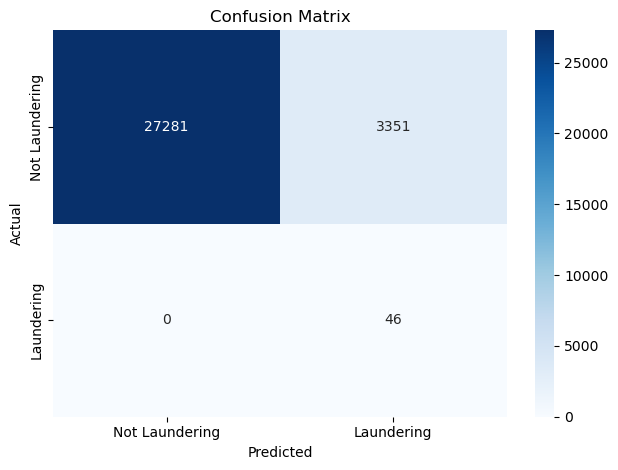

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Laundering", "Laundering"], yticklabels=["Not Laundering", "Laundering"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# 6,379,649 --> total transactions
# 5,586,578 --> true negatives
# 785,979 --> false positive --> 12.32009% 
# 6210 -> true positive  --> 0.09% 
# 882 --> false negative

In [21]:
# torch.save(best_model, "model_weights/best_aml_model_regularized.pth")

# model.load_state_dict(torch.load("best_aml_model.pth"))
# model.eval()


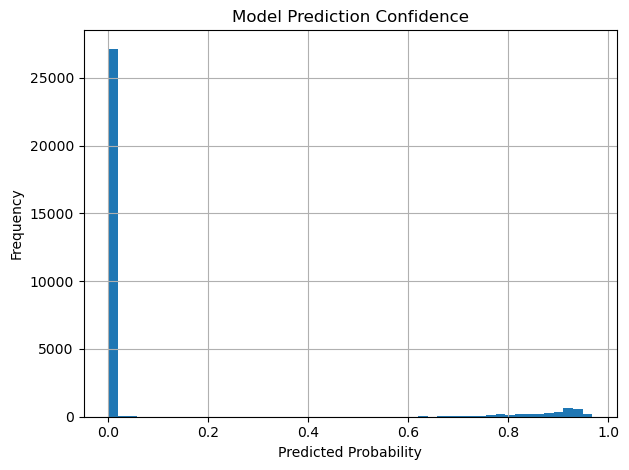

In [22]:
plt.hist(y_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Model Prediction Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()


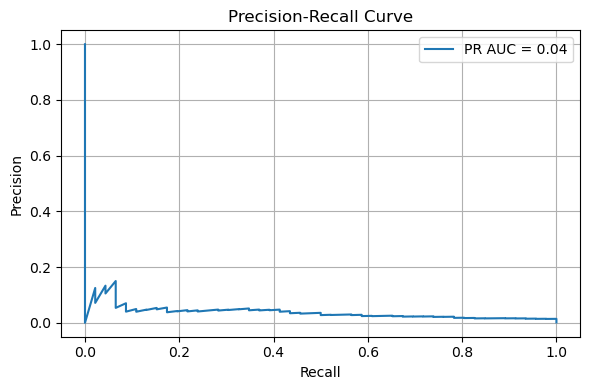

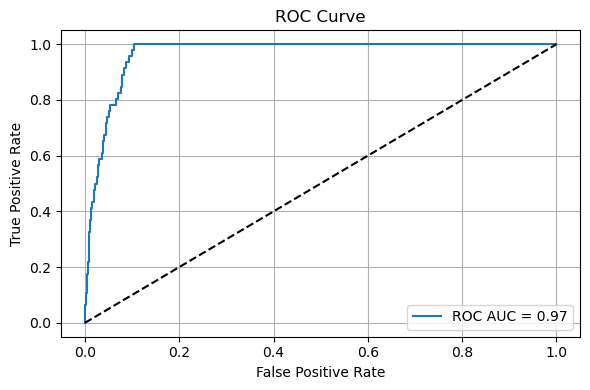

In [23]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [12]:
from sklearn.inspection import permutation_importance

# Wrap model in a function that takes numpy and outputs probabilities
def model_predict(X_numpy):
    with torch.no_grad():
        X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).numpy().ravel()
    return probs

from sklearn.metrics import roc_auc_score
result = permutation_importance(
    estimator=None,
    X=X,
    y=y.ravel(),
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    estimator_score=model_predict
)

# Plot
sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(np.array(features)[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance (by AUC)")
plt.tight_layout()
plt.show()


TypeError: permutation_importance() got an unexpected keyword argument 'estimator_score'